In [123]:
import numpy as np
import pandas as pd
import pyagrum as gum
import pyagrum.lib.notebook as gnb
import pyagrum.causal as csl
import pyagrum.causal.notebook as cslnb
import itertools

In [124]:
# Create the combined Bayesian Network
bn = gum.BayesNet("CombinedDepressionModel")

# -----------------------------------------
# Sociodemographic Branch
# -----------------------------------------

# Independent nodes
age = bn.add(gum.LabelizedVariable("Age", "Age category", 3))                       # 0 = Young, 1 = Middle, 2 = Old
education = bn.add(gum.LabelizedVariable("Education", "Education Level", 3))  # e.g., 0 = Low, 1 = Medium, 2 = High

econ = bn.add(gum.LabelizedVariable("Income", "Income", 3))      # 0 = Low, 1 = Medium, 2 = High
bn.addArc(age, econ)
bn.addArc(education, econ)

# Aggregated SocioStatus [0 = Low, 1 = Medium, 2 = High]
socio = bn.add(gum.LabelizedVariable("SocioStatus", "Overall sociodemographic status", 3))
bn.addArc(age, socio)
bn.addArc(econ, socio)


# -----------------------------------------
# Physical Health Branch
# -----------------------------------------
chronic = bn.add(gum.LabelizedVariable("ChronicIllness", "Chronic Illness", 2))       # 0 = Absent, 1 = Present
obesity = bn.add(gum.LabelizedVariable("Obesity", "Obesity", 2))                      # 0 = Not Obese, 1 = Obese

# Aggregated PhysicalHealth [0 = Good, 1 = Moderate, 2 = Poor]
physhealth = bn.add(gum.LabelizedVariable("PhysicalHealth", "Overall Physical Health", 3))
bn.addArc(chronic, physhealth)
bn.addArc(obesity, physhealth)

# -----------------------------------------
# Additional Independent Nodes
# -----------------------------------------

# Genetic Predisposition (0 = Absent, 1 = Present)
genetic = bn.add(gum.LabelizedVariable("GeneticPredisposition", "Genetic Predisposition", 2))
bn.cpt(genetic).fillWith([0.8, 0.2])  # e.g., 80% do not have a genetic predisposition

# Adverse Childhood Experiences (ACE) (0 = Absent, 1 = Present)
adverse = bn.add(gum.LabelizedVariable("AdverseChildhood", "Adverse Childhood Experiences", 2))
bn.cpt(adverse).fillWith([0.7, 0.3])  # e.g., 70% report no ACE, 30% do

# -----------------------------------------
# Outcome Node: Depression Severity
# -----------------------------------------
# States: 0 = No Depression, 1 = Low, 2 = Medium, 3 = Severe
depress = bn.add(gum.LabelizedVariable("Depression", "Depression", 2))
# DepressionSeverity is now influenced by SocioStatus, PhysicalHealth, GeneticPredisposition, and AdverseChildhood.
bn.addArc(socio, depress)
bn.addArc(physhealth, depress)
bn.addArc(genetic, depress)
bn.addArc(adverse, depress)

In [125]:
# -----------------------------------------
# Setting Up the CPTs for the Other Nodes
# -----------------------------------------

# Sociodemographic branch
bn.cpt(education).fillWith([0.5, 0.3, 0.2])  
bn.cpt(age).fillWith([0.6, 0.3, 0.1])
# For Income (now conditioned on both Age and Education), we specify 9 rows.
cpt_econ = bn.cpt(econ)

# For Young individuals (Age = 0):
cpt_econ[{'Age': 0, 'Education': 0}] = [0.9, 0.09, 0.01]   # Low education: higher chance of low income.
cpt_econ[{'Age': 0, 'Education': 1}] = [0.80, 0.15, 0.05]   # Medium education.
cpt_econ[{'Age': 0, 'Education': 2}] = [0.70, 0.20, 0.1]   # High education: higher chance of medium/high income.

# For Middle-aged individuals (Age = 1):
cpt_econ[{'Age': 1, 'Education': 0}] = [0.80, 0.15, 0.05]   # Low education.
cpt_econ[{'Age': 1, 'Education': 1}] = [0.70, 0.20, 0.1]   # Medium education.
cpt_econ[{'Age': 1, 'Education': 2}] = [0.5, 0.3, 0.2]   # High education.

# For Old individuals (Age = 2):
cpt_econ[{'Age': 2, 'Education': 0}] = [0.70, 0.20, 0.1]    # Low education.
cpt_econ[{'Age': 2, 'Education': 1}] = [0.5, 0.3, 0.2]   # Medium education.
cpt_econ[{'Age': 2, 'Education': 2}] = [0.3, 0.4, 0.3]   # High education.


In [126]:
# Assume that 'bn' is your Bayesian network and 'socio' is the aggregated SocioStatus node.
# The CPT for SocioStatus has 3 outcomes (e.g., 0 = Low, 1 = Medium, 2 = High).
cpt_socio = bn.cpt(socio)

# --- For Age = 0 (Young) ---
cpt_socio[{'Age': 0, 'Income': 0}] = [0.95, 0.04, 0.01]
cpt_socio[{'Age': 0, 'Income': 1}] = [0.90, 0.07, 0.03]
cpt_socio[{'Age': 0, 'Income': 2}] = [0.85, 0.10, 0.05]

# --- For Age = 1 (Middle-aged) ---
# Directly assigning the averaged values from before:
cpt_socio[{'Age': 1, 'Income': 0}] = [0.50, 0.35, 0.15]   
cpt_socio[{'Age': 1, 'Income': 1}] = [0.40, 0.40, 0.20]   
cpt_socio[{'Age': 1, 'Income': 2}] = [0.30, 0.45, 0.25]  

# --- For Age = 2 (Old) ---
cpt_socio[{'Age': 2, 'Income': 0}] = [0.30, 0.40, 0.30] 
cpt_socio[{'Age': 2, 'Income': 1}] = [0.23, 0.40, 0.38]  
cpt_socio[{'Age': 2, 'Income': 2}] = [0.15, 0.40, 0.45]

In [127]:
# Physical Health branch
bn.cpt(chronic).fillWith([0.95, 0.05])
bn.cpt(obesity).fillWith([0.7, 0.3])

(pyagrum.Tensor@000002C4F16F8480) 
  Obesity          |
0        |1        |
---------|---------|
 0.7000  | 0.3000  |

In [128]:
# Assuming 'bn' is your Bayesian network and 'physhealth' is the aggregated PhysicalHealth node.
cpt_physHealth = bn.cpt(physhealth)

# When ChronicIllness is Absent (0) and Obesity is Not Obese (0)
cpt_physHealth[{'ChronicIllness': 0, 'Obesity': 0}] = [0.95, 0.04, 0.01]

# When ChronicIllness is Absent (0) and Obesity is Present (1)
cpt_physHealth[{'ChronicIllness': 0, 'Obesity': 1}] = [0.60, 0.30, 0.10]

# When ChronicIllness is Present (1) and Obesity is Not Obese (0)
cpt_physHealth[{'ChronicIllness': 1, 'Obesity': 0}] = [0.40, 0.30, 0.30]

# When ChronicIllness is Present (1) and Obesity is Present (1)
cpt_physHealth[{'ChronicIllness': 1, 'Obesity': 1}] = [0.2, 0.35, 0.45]



In [129]:
# --- Define risk parameters ---
# These values represent the triggering chances for each contributing factor
ss_params = {0: 0.1, 1: 0.05, 2: 0.0}   # For SocioStatus: 0 = Low, 1 = Medium, 2 = High (protective)
ph_params = {0: 0.0, 1: 0.1, 2: 0.2}   # For PhysicalHealth: 0 = Good, 1 = Moderate, 2 = Poor
ace_params = {0: 0.1, 1: 0.3}          # For ACE: 0 = Absent, 1 = Present
# Here Genetic does not directly trigger depression; instead, it multiplies the baseline probability.
gp_multiplier = {0: 1.0, 1: 1.5}         # If GeneticPredisposition is present (state 1), multiply baseline by 1.5
leak = 0.01                             # A small baseline risk

# --- Retrieve and fill the CPT for Depression ---
# The expected tensor has dimensions: 3 (SocioStatus) x 3 (PhysicalHealth) x 2 (ACE) x 2 (Genetic) x 2 (Depression)
# That is a total of 3x3x2x2x2 = 72 cells.
cpt_depress = bn.cpt(depress)
cpt_values = []  # will accumulate a flat list of 72 numbers

# For each combination of parent states:
for ss, ph, ace_state, gp_state in itertools.product(range(3), range(3), range(2), range(2)):
    # Compute the baseline probability without Genetic:
    prod_failure = (1 - ss_params[ss]) * (1 - ph_params[ph]) * (1 - ace_params[ace_state]) * (1 - leak)
    p_baseline = 1 - prod_failure  # noisy-OR probability from these factors
    
    # Now, if GeneticPredisposition is present (gp_state == 1),
    # multiply the baseline probability. Note that if p_baseline is zero,
    # genetic alone will not generate risk.
    if gp_state == 1:
        p_dep = min(1.0, p_baseline * gp_multiplier[1])
    else:
        p_dep = p_baseline

    # For a binary outcome, the CPT row is: [P(No Depression), P(Depression)]
    cpt_values.extend([1 - p_dep, p_dep])

# Use fillWith with a flat list of 72 values
cpt_depress.fillWith(cpt_values)

# --- Print the resulting CPT ---
print("CPT for Depression (with ACE and Genetic as multiplier):")
print(cpt_depress)

CPT for Depression (with ACE and Genetic as multiplier):

                           ||  Depression       |
SocioS|Physic|Geneti|Advers||0        |1        |
------|------|------|------||---------|---------|
0     |0     |0     |0     || 0.8019  | 0.1981  |
1     |0     |0     |0     || 0.7029  | 0.2971  |
2     |0     |0     |0     || 0.6237  | 0.3763  |
0     |1     |0     |0     || 0.4356  | 0.5644  |
1     |1     |0     |0     || 0.7217  | 0.2783  |
2     |1     |0     |0     || 0.5826  | 0.4174  |
[...24 more line(s) ...]
0     |1     |1     |1     || 0.6237  | 0.3763  |
1     |1     |1     |1     || 0.4356  | 0.5644  |
2     |1     |1     |1     || 0.7128  | 0.2872  |
0     |2     |1     |1     || 0.5692  | 0.4308  |
1     |2     |1     |1     || 0.5544  | 0.4456  |
2     |2     |1     |1     || 0.3316  | 0.6684  |



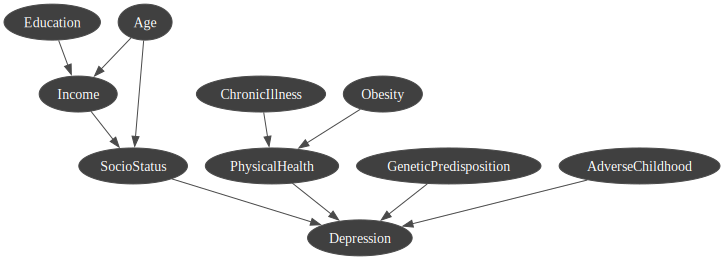

In [ ]:
# Set up the inference engine
ie = gum.LazyPropagation(bn)
gnb.show(bn, size="11")  # Increase graphical scaling

In [132]:
# Iterate over all nodes in the BN and show their CPTs:
for node in bn.nodes():
    var_name = bn.variable(node).name()
    print(f"Statistics for {var_name}:")
    gnb.showPotential(bn.cpt(node))

Statistics for Age:


Statistics for Education:


Statistics for Income:


Statistics for SocioStatus:


Statistics for ChronicIllness:


Statistics for Obesity:


Statistics for PhysicalHealth:


Statistics for GeneticPredisposition:


Statistics for AdverseChildhood:


Statistics for Depression:


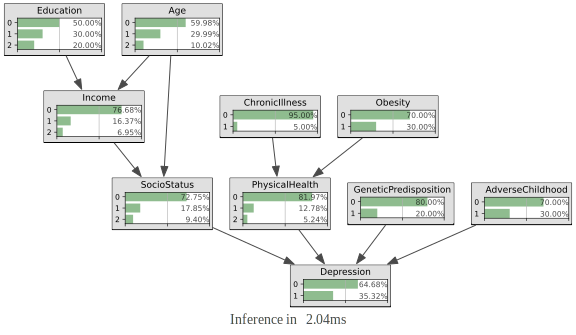

In [133]:
# Use bn (the BayesNet) as the model and pass the inference engine with the 'engine' keyword.
gnb.showInference(bn, engine=ie)
